In [1]:
skip_predict_test = False        
verbose = False
GPU_SETTING = -1
BASIN = "calpella"  # calpella | warm_springs | hopland | guerneville
MODE  = "mts"     # options are "daily" / "hourly" / "mts"           
RUN_LABEL = "BASELINE"
READ_STAMP = "20250815T000000Z"   # Example: None to use latest / "20250815T000000Z" to use an archived folder /      

In [2]:
import sys
import os, json
from pathlib import Path
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [3]:
library_path = os.path.join('..', '..', '..', 'UCB-USACE-RR-PROJECT')
sys.path.insert(0, library_path)
current_dir = os.getcwd()
print(current_dir)

/Users/canruso/Desktop/UCB-USACE-LSTMs/notebooks/reload_repredict


In [4]:
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (data_dir, set_active_context, ensure_shared_tree, repo_root, runs_latest_path, to_path_or_list, ensure_output_tree, prepare_out_path)

In [5]:
set_active_context(basin=BASIN, resolution=MODE, run_stamp=None, run_tag=RUN_LABEL, append_stamp_to_filenames=False)
SHARED = ensure_shared_tree(BASIN, MODE)
ensure_output_tree(BASIN, MODE)

PosixPath('/Users/canruso/Desktop/UCB-USACE-LSTMs/outputs/calpella/mts')

In [6]:
if READ_STAMP:
    RUNS_FILE = (SHARED / "runs" / "archive" /
                 f"{BASIN}_{MODE}_{RUN_LABEL}_stored_runs_{READ_STAMP}.json")
else:
    RUNS_FILE = runs_latest_path(BASIN, MODE, RUN_LABEL)

saved = json.loads(Path(RUNS_FILE).read_text())

In [7]:
SPECIAL_PREFIX = {"warm_springs": "WarmSprings_Inflow"}


BASIN_PREFIX = SPECIAL_PREFIX.get(BASIN.lower(), BASIN.replace("_", " ").title().replace(" ", ""))

d = data_dir()

if MODE == "daily":
    
    candidates = [f"{BASIN_PREFIX}_daily_shift.csv", f"{BASIN_PREFIX}_daily.csv"]
    for fn in candidates:
        p = d / fn
        if p.exists():
            hms_csv = p.resolve()
            break
    else:
        raise FileNotFoundError(f"Daily HMS CSV not found for {BASIN} under {d}")

elif MODE == "hourly":
    p = d / f"{BASIN_PREFIX}_hourly.csv"
    if not p.exists():
        raise FileNotFoundError(f"Hourly HMS CSV not found for {BASIN} under {d}")
    hms_csv = p.resolve()

elif MODE == "mts":
    for fn in [f"{BASIN_PREFIX}_daily_averaged.csv",
               f"{BASIN_PREFIX}_daily_shift.csv",
               f"{BASIN_PREFIX}_daily.csv"]:
        p = d / fn
        if p.exists():
            hms_csv_1D = p.resolve()
            break
    else:
        raise FileNotFoundError(f"MTS 1D HMS CSV not found for {BASIN} under {d}")

    p = d / f"{BASIN_PREFIX}_hourly.csv"
    if not p.exists():
        raise FileNotFoundError(f"MTS 1H HMS CSV not found for {BASIN} under {d}")
    hms_csv_1H = p.resolve()

In [8]:
runner_np = UCB_trainer.from_run_dir(to_path_or_list(saved["no_physics"]), gpu=GPU_SETTING, verbose=verbose)
runner_ph = UCB_trainer.from_run_dir(to_path_or_list(saved["physics"]), gpu=GPU_SETTING, verbose=verbose)

[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00, 65.71it/s]


[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00, 67.49it/s]


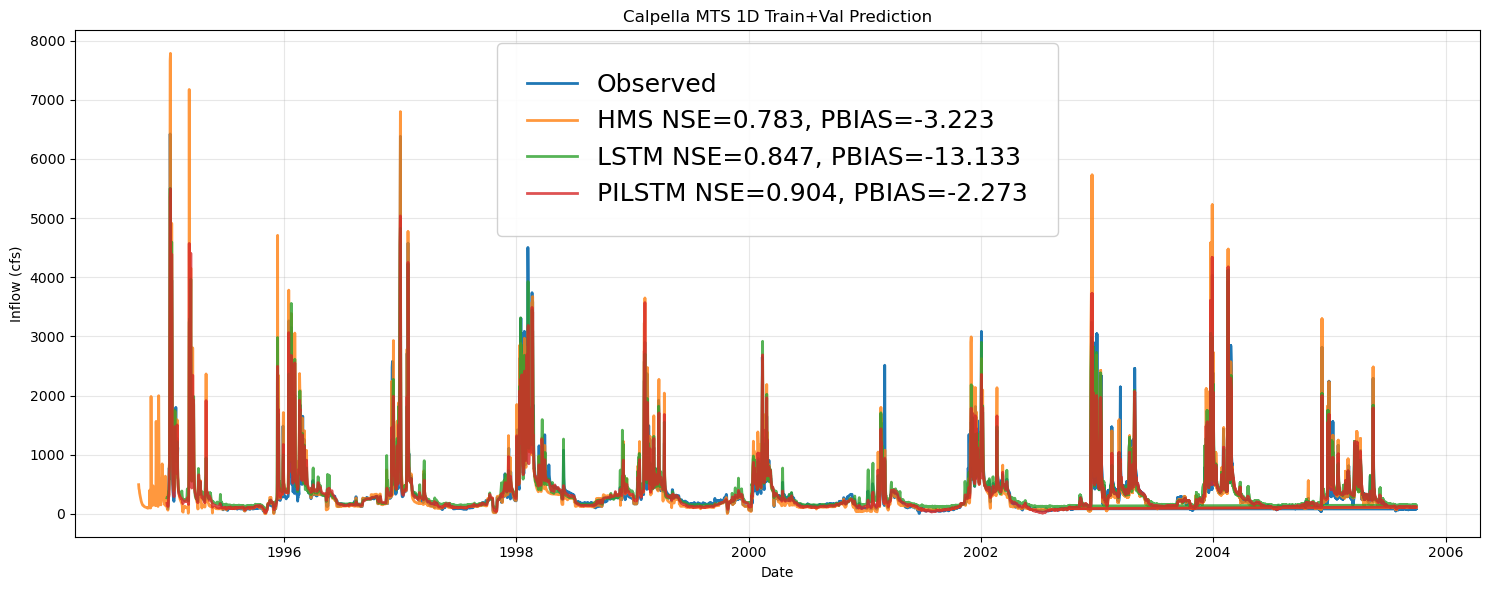

[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00, 71.79it/s]


[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00, 71.82it/s]


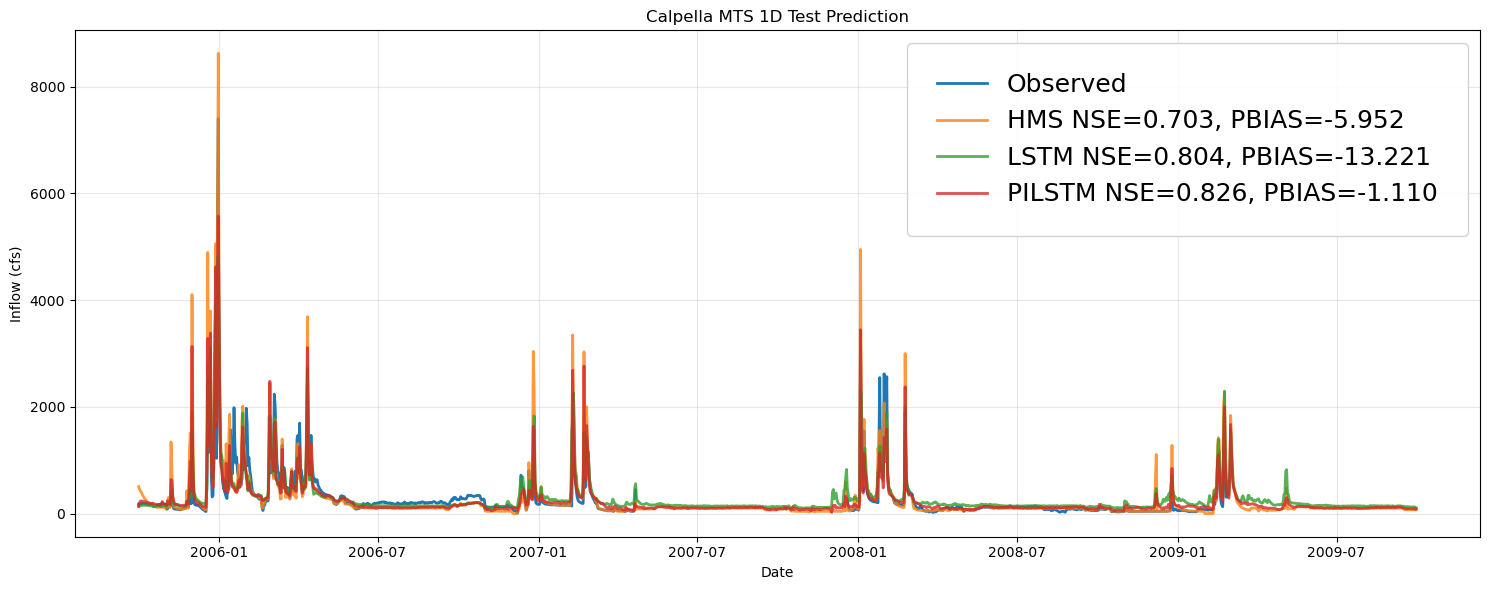

[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00, 69.07it/s]


[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00, 59.96it/s]


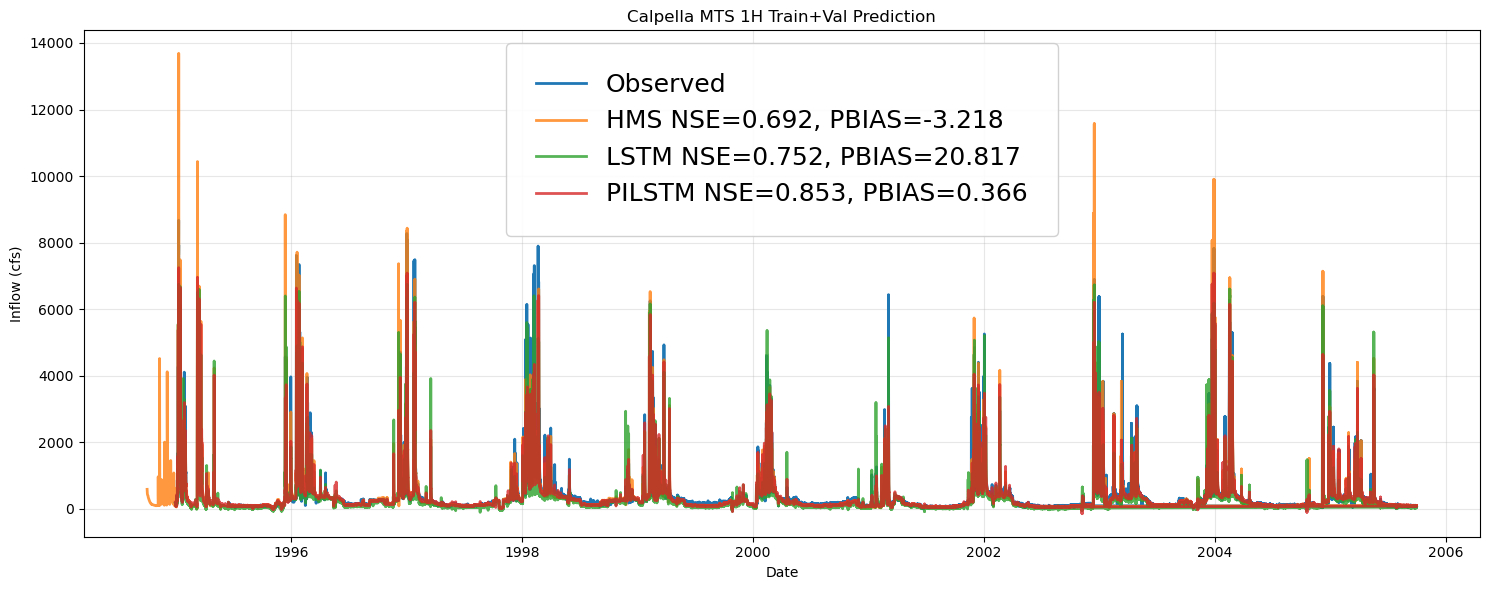

[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00, 59.83it/s]


[DEBUG:_create_ensemble] => Starting function with frequencies: ['1H', '1D']


100%|██████████| 1/1 [00:00<00:00, 68.45it/s]


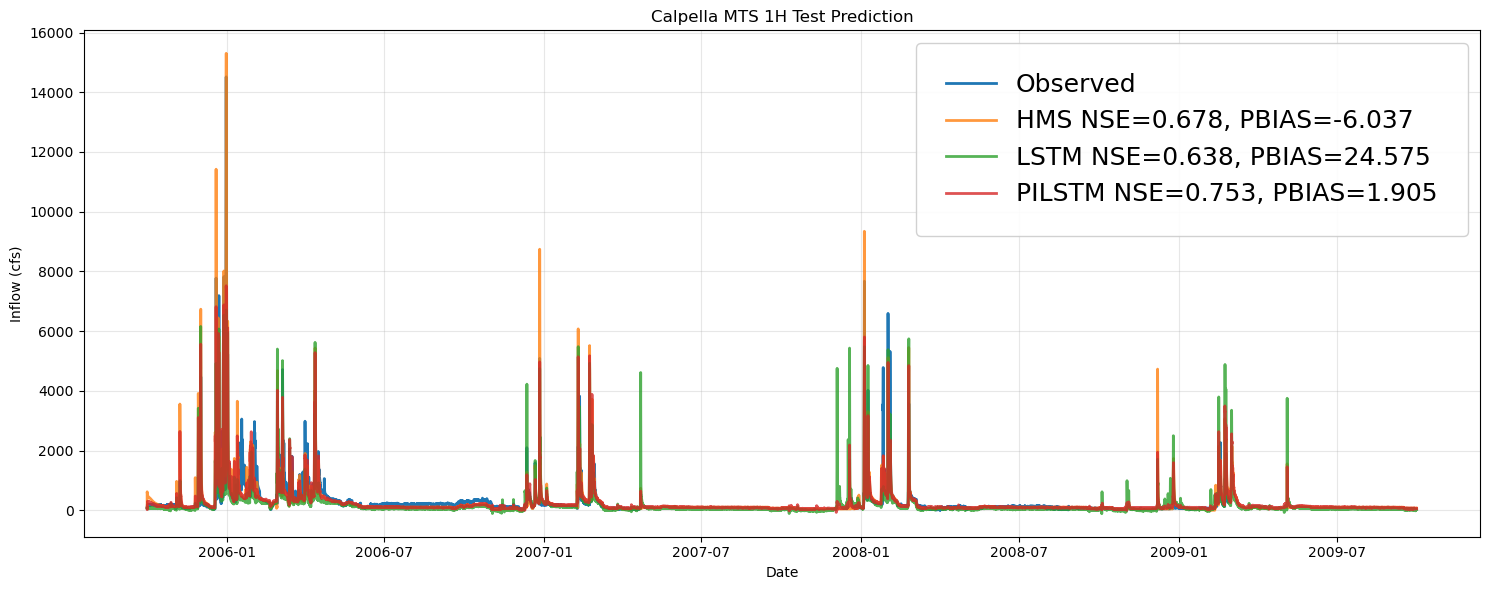

In [10]:
basin_file_ctx = (repo_root() / "UCB_training" / "models" / f"{BASIN}_all").resolve()
if not (basin_file_ctx / BASIN).exists():
    raise FileNotFoundError(f"Expected basin list file '{BASIN}' under {basin_file_ctx} (e.g., {basin_file_ctx / BASIN})")

old_cwd = Path.cwd()
try:
    # Make relative basin-file paths like 'calpella' resolve for eval_run(...)
    os.chdir(basin_file_ctx)

    if MODE in ("daily", "hourly"):
        # Train+Val outputs (ensure folders exist)
        plot_tv = prepare_out_path(f"{BASIN}_{MODE}_trainval_ts_predict.png",  kind="plot_timeseries", period="train_val")
        ts_tv   = prepare_out_path(f"{BASIN}_{MODE}_trainval_ts_predict.csv",  kind="timeseries",     period="train_val")
        met_tv  = prepare_out_path(f"{BASIN}_{MODE}_trainval_metrics_predict.csv", kind="metrics",   period="train_val")
        plot_tv.parent.mkdir(parents=True, exist_ok=True); ts_tv.parent.mkdir(parents=True, exist_ok=True); met_tv.parent.mkdir(parents=True, exist_ok=True)

        runner_np.predict(period="train_validation", partner_trainer=runner_ph, hms_csv=hms_csv, metrics=["NSE", "PBIAS"],
                          plot_filename=plot_tv, timeseries_filename=ts_tv, metrics_filename=met_tv,
                          plot_title=f"{BASIN.capitalize()} {MODE.capitalize()} Train+Val Prediction")

        # Test outputs (ensure folders exist)
        if not skip_predict_test:
            plot_te = prepare_out_path(f"{BASIN}_{MODE}_test_ts_predict.png",   kind="plot_timeseries", period="test")
            ts_te   = prepare_out_path(f"{BASIN}_{MODE}_test_ts_predict.csv",   kind="timeseries",     period="test")
            met_te  = prepare_out_path(f"{BASIN}_{MODE}_test_metrics_predict.csv", kind="metrics",    period="test")
            plot_te.parent.mkdir(parents=True, exist_ok=True); ts_te.parent.mkdir(parents=True, exist_ok=True); met_te.parent.mkdir(parents=True, exist_ok=True)

            runner_np.predict(period="test", partner_trainer=runner_ph, hms_csv=hms_csv, metrics=["NSE", "PBIAS"],
                              plot_filename=plot_te, timeseries_filename=ts_te, metrics_filename=met_te,
                              plot_title=f"{BASIN.capitalize()} {MODE.capitalize()} Test Prediction")

    elif MODE == "mts":
        # Make sure the output trees exist; we'll still mkdir parents on each path before saving.
        ensure_output_tree(BASIN, "mts_daily")
        ensure_output_tree(BASIN, "mts_hourly")

        # ---- 1D branch ----
        set_active_context(basin=BASIN, resolution="mts_daily", run_stamp=None, run_tag=RUN_LABEL, append_stamp_to_filenames=False)

        plot_tv_1d = prepare_out_path(f"{BASIN}_mts_1D_trainval_ts_predict.png",  kind="plot_timeseries", period="train_val")
        ts_tv_1d   = prepare_out_path(f"{BASIN}_mts_1D_trainval_ts_predict.csv",  kind="timeseries",     period="train_val")
        met_tv_1d  = prepare_out_path(f"{BASIN}_mts_1D_trainval_metrics_predict.csv", kind="metrics",   period="train_val")
        plot_tv_1d.parent.mkdir(parents=True, exist_ok=True); ts_tv_1d.parent.mkdir(parents=True, exist_ok=True); met_tv_1d.parent.mkdir(parents=True, exist_ok=True)

        runner_np.predict(period="train_validation", partner_trainer=runner_ph, hms_csv=hms_csv_1D, metrics=["NSE", "PBIAS"],
                          plot_filename=plot_tv_1d, timeseries_filename=ts_tv_1d, metrics_filename=met_tv_1d,
                          plot_title=f"{BASIN.capitalize()} MTS 1D Train+Val Prediction", mts_trk="1D")

        if not skip_predict_test:
            plot_te_1d = prepare_out_path(f"{BASIN}_mts_1D_test_ts_predict.png",  kind="plot_timeseries", period="test")
            ts_te_1d   = prepare_out_path(f"{BASIN}_mts_1D_test_ts_predict.csv",  kind="timeseries",     period="test")
            met_te_1d  = prepare_out_path(f"{BASIN}_mts_1D_test_metrics_predict.csv", kind="metrics",   period="test")
            plot_te_1d.parent.mkdir(parents=True, exist_ok=True); ts_te_1d.parent.mkdir(parents=True, exist_ok=True); met_te_1d.parent.mkdir(parents=True, exist_ok=True)

            runner_np.predict(period="test", partner_trainer=runner_ph, hms_csv=hms_csv_1D, metrics=["NSE", "PBIAS"],
                              plot_filename=plot_te_1d, timeseries_filename=ts_te_1d, metrics_filename=met_te_1d,
                              plot_title=f"{BASIN.capitalize()} MTS 1D Test Prediction", mts_trk="1D")

        # ---- 1H branch ----
        set_active_context(basin=BASIN, resolution="mts_hourly", run_stamp=None, run_tag=RUN_LABEL, append_stamp_to_filenames=False)

        plot_tv_1h = prepare_out_path(f"{BASIN}_mts_1H_trainval_ts_predict.png",  kind="plot_timeseries", period="train_val")
        ts_tv_1h   = prepare_out_path(f"{BASIN}_mts_1H_trainval_ts_predict.csv",  kind="timeseries",     period="train_val")
        met_tv_1h  = prepare_out_path(f"{BASIN}_mts_1H_trainval_metrics_predict.csv", kind="metrics",   period="train_val")
        plot_tv_1h.parent.mkdir(parents=True, exist_ok=True); ts_tv_1h.parent.mkdir(parents=True, exist_ok=True); met_tv_1h.parent.mkdir(parents=True, exist_ok=True)

        runner_np.predict(period="train_validation", partner_trainer=runner_ph, hms_csv=hms_csv_1H, metrics=["NSE", "PBIAS"],
                          plot_filename=plot_tv_1h, timeseries_filename=ts_tv_1h, metrics_filename=met_tv_1h,
                          plot_title=f"{BASIN.capitalize()} MTS 1H Train+Val Prediction", mts_trk="1H")

        if not skip_predict_test:
            plot_te_1h = prepare_out_path(f"{BASIN}_mts_1H_test_ts_predict.png",  kind="plot_timeseries", period="test")
            ts_te_1h   = prepare_out_path(f"{BASIN}_mts_1H_test_ts_predict.csv",  kind="timeseries",     period="test")
            met_te_1h  = prepare_out_path(f"{BASIN}_mts_1H_test_metrics_predict.csv", kind="metrics",   period="test")
            plot_te_1h.parent.mkdir(parents=True, exist_ok=True); ts_te_1h.parent.mkdir(parents=True, exist_ok=True); met_te_1h.parent.mkdir(parents=True, exist_ok=True)

            runner_np.predict(period="test", partner_trainer=runner_ph, hms_csv=hms_csv_1H, metrics=["NSE", "PBIAS"],
                              plot_filename=plot_te_1h, timeseries_filename=ts_te_1h, metrics_filename=met_te_1h,
                              plot_title=f"{BASIN.capitalize()} MTS 1H Test Prediction", mts_trk="1H")

finally:
    os.chdir(old_cwd)